### Precision/Recall Replication
* Zweck: Replikation des Kapitel "Classification" aus dem Paper "Predicting Vulnerable Software Components"
* Matrix: Klassifikationsmatrix auf aktuellem Stand "current" des mozilla-central Repository
* Features: Includes, Function Calls
* Modell: Support Vector Machine Classifier

#### Setup
* Training-Set/Test-Set: Stratified sampling auf einer Matrix (2/3 : 1/3)

#### Results
Das Skript macht auf n verschiedenen Datensets eine Vorhersage und berechnet Precision und Recall. Diese werden im Scatterplot dargestellt und der deren Durchschnitt im print.
* Resultat Plot: Scatterplot Precision vs. Recall
* Resultat Print: Durchschnitt Precision vs. Recall über n Datensets

Includes            : 40/40
Function Calls      : 40/40
+----------------+---------------+------------+------------------------------+---------------------------+
| Features       | Precision avg | Recall avg | Precision standard deviation | Recall standard deviation |
+----------------+---------------+------------+------------------------------+---------------------------+
| Includes       |      0.69     |    0.35    |            0.031             |           0.031           |
| Function Calls |      0.74     |    0.36    |            0.021             |           0.021           |
+----------------+---------------+------------+------------------------------+---------------------------+


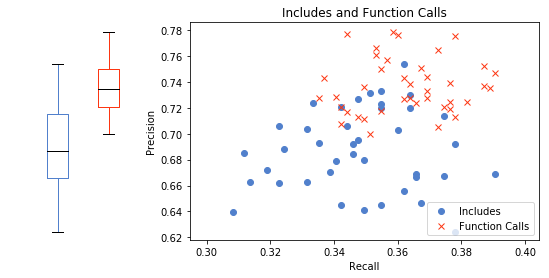

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
from sklearn.metrics import precision_recall_curve
from prettytable import PrettyTable

matrix_helper = MatrixHelper()
experiments_count = 40

features = [('incl', 'Includes', 'o', '#5180cc'), ('calls', 'Function Calls', 'x', '#FD3612')]
precision_lists = {}
recall_lists = {}

for feature in features:
    # Read pickle
    matrices = matrix_helper.load_from_parse('data/matrices/matrix_cla_{}_current.pickle'.format(feature[0]))
    precision_lists[feature[0]] = []
    recall_lists[feature[0]] = []
    
    for i in range(experiments_count):
        print '{:20}: {:2}/{:2}\r'.format(feature[1], i+1, experiments_count),
        # Instantiate Prediction Helper Class and predict values for compare matrix with an SVM
        prediction_helper = PredictionHelper()
        prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='LinearSVC')
        compare_matrix = prediction_helper.get_compare_matrix()

        # Compute Precision-Recall
        precision, recall, thresholds = precision_recall_curve(np.array(compare_matrix[:, 2], dtype='f'), np.array(compare_matrix[:, 1], dtype='f'))

        precision_lists[feature[0]].append(precision[1])
        recall_lists[feature[0]].append(recall[1])
    print


# plot
ymin = min([min(precision_lists[list]) for list in precision_lists])
ymax = max([max(precision_lists[list]) for list in precision_lists])

fig = plt.figure(figsize=(9, 4))

for i, feature in enumerate(features):
    ax = plt.subplot2grid((1, 10), (0, i))
    boxprops = dict(color=feature[3])
    flierprops = dict(markerfacecolor=feature[3],markeredgecolor=feature[3], marker=feature[2])
    whiskerprops = dict(color=feature[3])
    medianprops = dict(color='black')
    plt.boxplot(precision_lists[feature[0]], flierprops=flierprops, whiskerprops=whiskerprops, boxprops=boxprops, medianprops=medianprops, widths=(0.5))
    plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
    plt.axis('off')

ax = plt.subplot2grid((1, 10), (0, 3), colspan=7)
for feature in features:
    plt.scatter(recall_lists[feature[0]], precision_lists[feature[0]], edgecolor=feature[3], linewidth='1', facecolor=feature[3], marker=feature[2], label=feature[1])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(ymin=ymin/1.01, ymax=ymax*1.01)
plt.legend(loc=4)
ax.set_title('Includes and Function Calls')

fig.savefig('outputs/precision-recall-replication.pdf')

# print
print('==================================')
table = PrettyTable(['Features', 'Precision avg', 'Recall avg', 'Precision standard deviation', 'Recall standard deviation'])
table.align["Features"] = "l"
for feature in features:
    precision_average = '{:.2f}'.format(sum(precision_lists[feature[0]]) / float(len(precision_lists[feature[0]])))
    recall_average = '{:.2f}'.format(float(sum(recall_lists[feature[0]])) / len(recall_lists[feature[0]]))
    precision_sd = '{:.3f}'.format(np.std(precision_lists[feature[0]]))
    recall_sd = '{:.3f}'.format(np.std(recall_lists[feature[0]]))
    
    table.add_row([feature[1], precision_average, recall_average, precision_sd, recall_sd])
print(table)
print('==================================')
